# Setup

## Installation

In [4]:
!pip install xgboost

In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 3.3 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [16]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
import joblib

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading the Data & Preprocessing

In [8]:
clean_path = '/content/drive/MyDrive/AI_in_Industry/cleaned_choreographies.csv'
df = pd.read_csv(clean_path)
print("\nShape after preprocessing:", df.shape)


Shape after preprocessing: (8563, 32)


In [9]:
genre_cols = [c for c in df.columns if c.startswith('musicGenre_')]
target_cols = [
    'EvaluationChoreographyStoryTelling',
    'EvaluationChoreographyRhythm',
    'EvaluationChoreographyMovementTechnique',
    'EvaluationChoreographyPublicInvolvement',
    'EvaluationChoreographySpaceUse',
    'EvaluationChoreographyHumanCharacterization',
    'EvaluationChoreographyHumanReproducibility'
]

numeric_cols = [c for c in df.columns
                if c not in genre_cols + target_cols]

In [10]:
feature_cols = [
    'timeDuration','nMovements','movementsDifficulty','robotSpeech',
    'acrobaticMovements','movementsRepetition', 'movementsTransitionsDuration','humanMovements','balance',
    'speed','bodyPartsCombination','musicBPM','sameStartEndPositionPlace',
    'headMovement','armsMovement','handsMovement','legsMovement','feetMovement'
]
feature_cols += genre_cols

In [11]:
datasets = {}
for tgt in target_cols:
    datasets[tgt] = df[feature_cols + [tgt]].copy()

In [12]:
for tgt, d in datasets.items():
    print(f"{tgt}: {d.shape[0]} rows, {d.shape[1]} cols")

EvaluationChoreographyStoryTelling: 8563 rows, 26 cols
EvaluationChoreographyRhythm: 8563 rows, 26 cols
EvaluationChoreographyMovementTechnique: 8563 rows, 26 cols
EvaluationChoreographyPublicInvolvement: 8563 rows, 26 cols
EvaluationChoreographySpaceUse: 8563 rows, 26 cols
EvaluationChoreographyHumanCharacterization: 8563 rows, 26 cols
EvaluationChoreographyHumanReproducibility: 8563 rows, 26 cols


### Train/Val/Test Sets

#### Creating Sets

**You only need to run the section `Creating Sets` once.**

**For the next times, you can skip it and start from the next section `Loading Sets`.**

Sample a small `BACKGROUND` set from `X_train` for SHAP (e.g., 200 rows).

In [ ]:
output_dir = '/content/drive/MyDrive/AI_in_Industry/choreography_splits'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
for tgt in target_cols:
    X = df[feature_cols].copy()
    y = df[tgt].copy()

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.10, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=1/9, random_state=42
    )

    n_background = min(200, X_train.shape[0])
    X_background = X_train.sample(n=n_background, random_state=42)

    tgt_slug = (
        tgt
        .replace('EvaluationChoreography', '')
        .lower()
    )

    fn_X_train = os.path.join(output_dir, f'X_train_{tgt_slug}.csv')
    fn_X_val = os.path.join(output_dir, f'X_val_{tgt_slug}.csv')
    fn_X_test = os.path.join(output_dir, f'X_test_{tgt_slug}.csv')
    fn_y_train = os.path.join(output_dir, f'y_train_{tgt_slug}.csv')
    fn_y_val = os.path.join(output_dir, f'y_val_{tgt_slug}.csv')
    fn_y_test = os.path.join(output_dir, f'y_test_{tgt_slug}.csv')
    fn_X_background = os.path.join(output_dir, f'X_background_{tgt_slug}.csv')

    X_train.to_csv(fn_X_train, index=False)
    X_val.to_csv(fn_X_val, index=False)
    X_test.to_csv(fn_X_test, index=False)
    y_train.to_csv(fn_y_train, index=False)
    y_val.to_csv(fn_y_val, index=False)
    y_test.to_csv(fn_y_test, index=False)
    X_background.to_csv(fn_X_background, index=False)

    print(f"Saved CSVs for target '{tgt}' as slug '{tgt_slug}':")
    print(f"  - {fn_X_train}")
    print(f"  - {fn_X_val}")
    print(f"  - {fn_X_test}")
    print(f"  - {fn_y_train}")
    print(f"  - {fn_y_val}")
    print(f"  - {fn_y_test}")
    print(f"  - {fn_X_background}\n")

Saved CSVs for target 'EvaluationChoreographyStoryTelling' as slug 'storytelling':
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/X_train_storytelling.csv
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/X_val_storytelling.csv
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/X_test_storytelling.csv
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/y_train_storytelling.csv
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/y_val_storytelling.csv
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/y_test_storytelling.csv
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/X_background_storytelling.csv

Saved CSVs for target 'EvaluationChoreographyRhythm' as slug 'rhythm':
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/X_train_rhythm.csv
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/X_val_rhythm.csv
  - /content/drive/MyDrive/AI_in_Industry/choreography_splits/X_test_rhythm.c

Creating and downloading related CSVs for the `choreo_splits` as a zip file.

In [ ]:
shutil.make_archive('/content/drive/MyDrive/AI_in_Industry/choreo_splits', 'zip', '/content/drive/MyDrive/AI_in_Industry/choreography_splits')
files.download('/content/drive/MyDrive/AI_in_Industry/choreo_splits.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Loading Sets

In [13]:
splits_dir = '/content/drive/MyDrive/AI_in_Industry/choreography_splits'

In [14]:
target_slugs = {
    'storytelling': 'EvaluationChoreographyStoryTelling',
    'rhythm':      'EvaluationChoreographyRhythm',
    'movementtechnique': 'EvaluationChoreographyMovementTechnique',
    'publicinvolvement': 'EvaluationChoreographyPublicInvolvement',
    'spaceuse':       'EvaluationChoreographySpaceUse',
    'humancharacterization': 'EvaluationChoreographyHumanCharacterization',
    'humanreproducibility':  'EvaluationChoreographyHumanReproducibility'
}

splits = {}

for slug, full_target_name in target_slugs.items():
    fn_X_train  = os.path.join(splits_dir, f'X_train_{slug}.csv')
    fn_X_val    = os.path.join(splits_dir, f'X_val_{slug}.csv')
    fn_X_test   = os.path.join(splits_dir, f'X_test_{slug}.csv')
    fn_y_train  = os.path.join(splits_dir, f'y_train_{slug}.csv')
    fn_y_val    = os.path.join(splits_dir, f'y_val_{slug}.csv')
    fn_y_test   = os.path.join(splits_dir, f'y_test_{slug}.csv')
    # fn_X_bg     = os.path.join(splits_dir, f'X_background_{slug}.csv')  # optional

    X_train = pd.read_csv(fn_X_train)
    X_val   = pd.read_csv(fn_X_val)
    X_test  = pd.read_csv(fn_X_test)

    y_train = pd.read_csv(fn_y_train).iloc[:, 0]
    y_val   = pd.read_csv(fn_y_val).iloc[:, 0]
    y_test  = pd.read_csv(fn_y_test).iloc[:, 0]

    # (Optional) background set
    # X_background = pd.read_csv(fn_X_bg)

    splits[full_target_name] = {
        'X_train': X_train,
        'X_val':   X_val,
        'X_test':  X_test,
        'y_train': y_train,
        'y_val':   y_val,
        'y_test':  y_test,
        # 'X_background': X_background  # if you need it later
    }

In [15]:
for tgt_name, d in splits.items():
    print(
        f"{tgt_name:45s} → "
        f"train: {d['X_train'].shape[0]:4d}  | "
        f"val: {d['X_val'].shape[0]:4d}  | "
        f"test: {d['X_test'].shape[0]:4d}"
    )

EvaluationChoreographyStoryTelling            → train: 6849  | val:  857  | test:  857
EvaluationChoreographyRhythm                  → train: 6849  | val:  857  | test:  857
EvaluationChoreographyMovementTechnique       → train: 6849  | val:  857  | test:  857
EvaluationChoreographyPublicInvolvement       → train: 6849  | val:  857  | test:  857
EvaluationChoreographySpaceUse                → train: 6849  | val:  857  | test:  857
EvaluationChoreographyHumanCharacterization   → train: 6849  | val:  857  | test:  857
EvaluationChoreographyHumanReproducibility    → train: 6849  | val:  857  | test:  857


# Regression Models

## Ridge Regressor

In [ ]:
ridge_dir = '/content/drive/MyDrive/AI_in_Industry/hyper_ridge_pipelines'
os.makedirs(ridge_dir, exist_ok=True)

In [ ]:
ridge_results = []

ct_all = ColumnTransformer(
    [('scale_all', StandardScaler(), feature_cols)],
    remainder='passthrough'
)

param_grid = {
    'ridge__alpha': np.logspace(-3, 3, 7),      # from 0.001 to 1000
    'ridge__solver': ['auto', 'svd', 'cholesky', 'sag']
}

for tgt_name, data_dict in splits.items():
    X_train, X_val, X_test = (
        data_dict['X_train'], data_dict['X_val'], data_dict['X_test']
    )
    y_train, y_val, y_test = (
        data_dict['y_train'], data_dict['y_val'], data_dict['y_test']
    )

    pipe = Pipeline([
        ('preproc', ct_all),
        ('ridge',   Ridge(random_state=42))
    ])

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    gs.fit(X_train, y_train)

    best_pipe = gs.best_estimator_
    best_alpha = gs.best_params_['ridge__alpha']

    y_val_pred  = best_pipe.predict(X_val)
    y_test_pred = best_pipe.predict(X_test)

    val_mae  = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2   = r2_score(y_val, y_val_pred)

    test_mae  = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2   = r2_score(y_test, y_test_pred)

    ridge_results.append({
        'target':      tgt_name,
        'best_alpha':  best_alpha,
        'val_MAE':     val_mae,
        'val_RMSE':    val_rmse,
        'val_R2':      val_r2,
        'test_MAE':    test_mae,
        'test_RMSE':   test_rmse,
        'test_R2':     test_r2
    })

    slug = tgt_name.replace('EvaluationChoreography', '').lower()
    pipeline_path = os.path.join(ridge_dir, f'ridge_pipeline_{slug}.pkl')
    joblib.dump(best_pipe, pipeline_path)

    n_background = min(200, X_train.shape[0])
    X_background = X_train.sample(n=n_background, random_state=42)
    X_background.to_csv(
        os.path.join(ridge_dir, f'X_background_{slug}.csv'),
        index=False
    )

ridge_df = pd.DataFrame(ridge_results).set_index('target')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [ ]:
print("Ridge Regression Performance:")
display(ridge_df)

Ridge Regression Performance:


,best_alpha,val_MAE,val_RMSE,val_R2,test_MAE,test_RMSE,test_R2
target,,,,,,,
EvaluationChoreographyStoryTelling,100.0,0.947911,1.119011,0.101055,0.952698,1.130299,0.083751
EvaluationChoreographyRhythm,100.0,0.961030,1.145397,0.074502,0.976926,1.150731,0.084944
EvaluationChoreographyMovementTechnique,1000.0,0.839090,1.034021,0.039940,0.798341,1.005560,0.027221
EvaluationChoreographyPublicInvolvement,100.0,0.937121,1.116802,0.041166,0.971074,1.145818,0.054805
EvaluationChoreographySpaceUse,1000.0,0.838511,1.014149,0.052336,0.794569,0.988417,0.053380
EvaluationChoreographyHumanCharacterization,1000.0,0.916423,1.112189,0.001589,0.894136,1.087883,-0.001572
EvaluationChoreographyHumanReproducibility,1000.0,0.694686,0.965336,0.019991,0.716234,1.009764,-0.014481


In [ ]:
print(f"Saved Ridge pipelines and background files in: {ridge_dir}")

Saved Ridge pipelines and background files in: /content/drive/MyDrive/AI_in_Industry/hyper_ridge_pipelines


Creating and downloading related CSVs for the `hyper_ridge_pipelines` as a zip file.

In [ ]:
shutil.make_archive('/content/drive/MyDrive/AI_in_Industry/hyper_ridge_pipelines', 'zip', '/content/drive/MyDrive/AI_in_Industry/hyper_ridge_pipelines')
files.download('/content/drive/MyDrive/AI_in_Industry/hyper_ridge_pipelines.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## XGBoost Regressor

In [ ]:
xgb_dir = '/content/drive/MyDrive/AI_in_Industry/hyper_xgb_models'
os.makedirs(xgb_dir, exist_ok=True)

In [ ]:
xgb_results = []

param_grid = {
    'n_estimators':    [100, 250, 500],
    'learning_rate':   [0.01, 0.05, 0.1],
    'max_depth':       [3, 6, 9],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0]
}


for tgt_name, data_dict in splits.items():
    X_train, X_val, X_test = (
        data_dict['X_train'], data_dict['X_val'], data_dict['X_test']
    )
    y_train, y_val, y_test = (
        data_dict['y_train'], data_dict['y_val'], data_dict['y_test']
    )

    xgb = XGBRegressor(
        n_jobs=1,
        # subsample=0.8,
        # colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    )

    gs = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    gs.fit(X_train, y_train)

    best_xgb = gs.best_estimator_
    best_params = gs.best_params_

    y_val_pred  = best_xgb.predict(X_val)
    y_test_pred = best_xgb.predict(X_test)

    val_mae  = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2   = r2_score(y_val, y_val_pred)

    test_mae  = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2   = r2_score(y_test, y_test_pred)

    xgb_results.append({
        'target':          tgt_name,
        'best_n_estimators':    best_params['n_estimators'],
        'best_max_depth':       best_params['max_depth'],
        'val_MAE':         val_mae,
        'val_RMSE':        val_rmse,
        'val_R2':          val_r2,
        'test_MAE':        test_mae,
        'test_RMSE':       test_rmse,
        'test_R2':         test_r2
    })

    slug = tgt_name.replace('EvaluationChoreography', '').lower()
    model_path = os.path.join(xgb_dir, f'xgb_model_{slug}.json')
    best_xgb.save_model(model_path)

    n_background = min(200, X_train.shape[0])
    X_background = X_train.sample(n=n_background, random_state=42)
    X_background.to_csv(
        os.path.join(xgb_dir, f'X_background_{slug}.csv'),
        index=False
    )

xgboost_df = pd.DataFrame(xgb_results).set_index('target')


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
print("XGBoost Regression Performance:")
display(xgboost_df)

XGBoost Regression Performance:


,best_n_estimators,best_max_depth,val_MAE,val_RMSE,val_R2,test_MAE,test_RMSE,test_R2
target,,,,,,,,
EvaluationChoreographyStoryTelling,250,6,0.913948,1.085049,0.154792,0.905249,1.087989,0.151063
EvaluationChoreographyRhythm,250,6,0.894677,1.073175,0.187536,0.912539,1.095655,0.170440
EvaluationChoreographyMovementTechnique,250,6,0.823688,1.015849,0.073388,0.785885,0.987609,0.061644
EvaluationChoreographyPublicInvolvement,500,3,0.892801,1.071379,0.117576,0.931218,1.096627,0.134219
EvaluationChoreographySpaceUse,100,3,0.815667,0.979945,0.115181,0.783869,0.965691,0.096411
EvaluationChoreographyHumanCharacterization,250,6,0.900059,1.087620,0.045215,0.898060,1.081535,0.010083
EvaluationChoreographyHumanReproducibility,100,6,0.690004,0.957517,0.035801,0.704157,0.995215,0.014543


In [ ]:
print(f"\nSaved XGBoost models and background files in: {xgb_dir}")


Saved XGBoost models and background files in: /content/drive/MyDrive/AI_in_Industry/hyper_xgb_models


Creating and downloading related CSVs for the `hyper_xgb_models` as a zip file.

In [ ]:
shutil.make_archive('/content/drive/MyDrive/AI_in_Industry/hyper_xgb_models', 'zip', '/content/drive/MyDrive/AI_in_Industry/hyper_xgb_models')
files.download('/content/drive/MyDrive/AI_in_Industry/hyper_xgb_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CatBoost Regressor

In [17]:
cb_dir = '/content/drive/MyDrive/AI_in_Industry/hyper_catboost_models'
os.makedirs(cb_dir, exist_ok=True)

In [ ]:
catboost_results = []

param_grid = {
    'iterations':    [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth':         [4, 6, 8],
    'l2_leaf_reg':   [1, 3, 5],
}

for tgt_name, data_dict in splits.items():
    X_train, X_val, X_test = (
        data_dict['X_train'].copy(),
        data_dict['X_val'].copy(),
        data_dict['X_test'].copy()
    )
    y_train, y_val, y_test = (
        data_dict['y_train'],
        data_dict['y_val'],
        data_dict['y_test']
    )

    base_cb = CatBoostRegressor(
        # l2_leaf_reg=3,
        loss_function='RMSE',
        od_type='Iter',
        od_wait=50,
        random_seed=42,
        verbose=0
    )

    gs = GridSearchCV(
        estimator=base_cb,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    gs.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        use_best_model=True
    )

    best_cb    = gs.best_estimator_
    best_params = gs.best_params_

    y_val_pred  = best_cb.predict(X_val)
    y_test_pred = best_cb.predict(X_test)

    val_mae   = mean_absolute_error(y_val, y_val_pred)
    val_rmse  = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2    = r2_score(y_val, y_val_pred)

    test_mae  = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2   = r2_score(y_test, y_test_pred)

    catboost_results.append({
        'target':               tgt_name,
        'best_iterations':      best_params['iterations'],
        'best_depth':           best_params['depth'],
        'val_MAE':              val_mae,
        'val_RMSE':             val_rmse,
        'val_R2':               val_r2,
        'test_MAE':             test_mae,
        'test_RMSE':            test_rmse,
        'test_R2':              test_r2
    })

    slug = tgt_name.replace('EvaluationChoreography','').lower()
    model_path = os.path.join(cb_dir, f'catboost_{slug}.cbm')
    best_cb.save_model(model_path)

    n_background = min(200, X_train.shape[0])
    X_background = X_train.sample(n=n_background, random_state=42)
    X_background.to_csv(
        os.path.join(cb_dir, f'X_background_{slug}.csv'),
        index=False
    )

catboost_df = pd.DataFrame(catboost_results).set_index('target')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
print("CatBoost Regression Performance:")
display(catboost_df)

CatBoost Regression Performance:


,best_iterations,best_depth,val_MAE,val_RMSE,val_R2,test_MAE,test_RMSE,test_R2
target,,,,,,,,
EvaluationChoreographyStoryTelling,500,4,0.906616,1.080496,0.161870,0.906578,1.093754,0.142042
EvaluationChoreographyRhythm,500,4,0.897217,1.082629,0.173158,0.908118,1.092725,0.174870
EvaluationChoreographyMovementTechnique,500,4,0.825461,1.013445,0.077767,0.789011,0.985597,0.065463
EvaluationChoreographyPublicInvolvement,500,4,0.893666,1.070906,0.118356,0.933598,1.098446,0.131346
EvaluationChoreographySpaceUse,1000,6,0.820233,0.983017,0.109624,0.786885,0.964559,0.098527
EvaluationChoreographyHumanCharacterization,500,4,0.902273,1.086544,0.047101,0.891291,1.075664,0.020801
EvaluationChoreographyHumanReproducibility,1000,4,0.696424,0.955945,0.038964,0.711434,0.994344,0.016266


In [ ]:
print(f"\nSaved CatBoost models + background sets in: {cb_dir}")


Saved CatBoost models + background sets in: /content/drive/MyDrive/AI_in_Industry/hyper_catboost_models


Creating and downloading related CSVs for the `hyper_catboost_models` as a zip file.

In [ ]:
shutil.make_archive('/content/drive/MyDrive/AI_in_Industry/hyper_catboost_models', 'zip', '/content/drive/MyDrive/AI_in_Industry/hyper_catboost_models')
files.download('/content/drive/MyDrive/AI_in_Industry/hyper_catboost_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## MLP Regressor

In [ ]:
nn_output_dir = '/content/drive/MyDrive/AI_in_Industry/nn_models'
os.makedirs(nn_output_dir, exist_ok=True)

In [ ]:
def build_mlp(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
nn_results = []

for tgt_name, data_dict in splits.items():
    X_train_raw = data_dict['X_train'].copy()
    X_val_raw   = data_dict['X_val'].copy()
    X_test_raw  = data_dict['X_test'].copy()
    y_train     = data_dict['y_train']
    y_val       = data_dict['y_val']
    y_test      = data_dict['y_test']

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_val   = scaler.transform(X_val_raw)
    X_test  = scaler.transform(X_test_raw)

    input_dim = X_train.shape[1]
    model = build_mlp(input_dim)

    slug = tgt_name.replace('EvaluationChoreography', '').lower()
    ckpt_path = os.path.join(nn_output_dir, f'mlp_best_{slug}.keras')
    es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    mc = ModelCheckpoint(filepath=ckpt_path, monitor='val_loss', save_best_only=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[es, mc],
        verbose=0
    )

    model = tf.keras.models.load_model(ckpt_path)

    y_val_pred  = model.predict(X_val).flatten()
    y_test_pred = model.predict(X_test).flatten()

    val_mae  = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2   = r2_score(y_val, y_val_pred)

    test_mae  = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2   = r2_score(y_test, y_test_pred)

    nn_results.append({
        'target':    tgt_name,
        'val_MAE':   val_mae,
        'val_RMSE':  val_rmse,
        'val_R2':    val_r2,
        'test_MAE':  test_mae,
        'test_RMSE': test_rmse,
        'test_R2':   test_r2
    })

    scaler_path = os.path.join(nn_output_dir, f'scaler_{slug}.pkl')
    joblib.dump(scaler, scaler_path)

    hist_df = pd.DataFrame(history.history)
    hist_path = os.path.join(nn_output_dir, f'history_{slug}.csv')
    hist_df.to_csv(hist_path, index=False)

nn_df = pd.DataFrame(nn_results).set_index('target')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
print("Neural Network (MLP) Regression Performance:")
display(nn_df)

Neural Network (MLP) Regression Performance:


,val_MAE,val_RMSE,val_R2,test_MAE,test_RMSE,test_R2
target,,,,,,
EvaluationChoreographyStoryTelling,0.945710,1.117475,0.103521,0.948815,1.129202,0.085529
EvaluationChoreographyRhythm,0.946986,1.127025,0.103953,0.957101,1.133831,0.111623
EvaluationChoreographyMovementTechnique,0.844509,1.038252,0.032067,0.809904,1.005591,0.027161
EvaluationChoreographyPublicInvolvement,0.914936,1.096022,0.076516,0.952197,1.126774,0.085964
EvaluationChoreographySpaceUse,0.844808,1.017138,0.046742,0.804723,0.992388,0.045760
EvaluationChoreographyHumanCharacterization,0.918903,1.114853,-0.003199,0.898998,1.089885,-0.005262
EvaluationChoreographyHumanReproducibility,0.714601,0.961942,0.026870,0.739425,1.005465,-0.005861


In [ ]:
print(f"\nSaved MLP weights, scalers, and history in: {nn_output_dir}")


Saved MLP weights, scalers, and history in: /content/drive/MyDrive/AI_in_Industry/nn_models


Creating and downloading related CSVs for the `nn_models` as a zip file.

In [ ]:
shutil.make_archive('/content/drive/MyDrive/AI_in_Industry/nn_models', 'zip', '/content/drive/MyDrive/AI_in_Industry/nn_models')
files.download('/content/drive/MyDrive/AI_in_Industry/nn_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PLOTS

In [ ]:
rows = []
for slug, target in target_slugs.items():
    X_test = pd.read_csv(os.path.join(splits_dir, f'X_test_{slug}.csv'))
    y_test = pd.read_csv(os.path.join(splits_dir, f'y_test_{slug}.csv')).iloc[:,0]

    # Ridge
    ridge_pipe = joblib.load(os.path.join(ridge_dir, f'ridge_pipeline_{slug}.pkl'))
    y_pred_r   = ridge_pipe.predict(X_test)
    rows.append({
        'model':'Ridge',
        'target':target,
        'MAE': ridge_df.loc[target, 'test_MAE'],
        'RMSE': ridge_df.loc[target, 'test_RMSE'],
        'R2':   ridge_df.loc[target, 'test_R2']
    })

    # XGBoost
    xgb = XGBRegressor()
    xgb.load_model(os.path.join(xgb_dir, f'xgb_model_{slug}.json'))
    y_pred_x = xgb.predict(X_test)
    rows.append({
        'model':'XGBoost',
        'target':target,
        'MAE': xgboost_df.loc[target, 'test_MAE'],
        'RMSE': xgboost_df.loc[target, 'test_RMSE'],
        'R2':   xgboost_df.loc[target, 'test_R2']
    })

    # CatBoost
    cb = CatBoostRegressor()
    cb.load_model(os.path.join(cb_dir, f'catboost_{slug}.cbm'))
    y_pred_c = cb.predict(X_test)
    rows.append({
        'model':'CatBoost',
        'target':target,
        'MAE': catboost_df.loc[target, 'test_MAE'],
        'RMSE': catboost_df.loc[target, 'test_RMSE'],
        'R2':   catboost_df.loc[target, 'test_R2']
    })

metrics_df = pd.DataFrame(rows)

In [ ]:
metrics_df

,model,target,MAE,RMSE,R2
0,Ridge,EvaluationChoreographyStoryTelling,0.952698,1.130299,0.083751
1,XGBoost,EvaluationChoreographyStoryTelling,0.905249,1.087989,0.151063
2,CatBoost,EvaluationChoreographyStoryTelling,0.906578,1.093754,0.142042
3,Ridge,EvaluationChoreographyRhythm,0.976926,1.150731,0.084944
4,XGBoost,EvaluationChoreographyRhythm,0.912539,1.095655,0.170440
5,CatBoost,EvaluationChoreographyRhythm,0.908118,1.092725,0.174870
6,Ridge,EvaluationChoreographyMovementTechnique,0.798341,1.005560,0.027221
7,XGBoost,EvaluationChoreographyMovementTechnique,0.785885,0.987609,0.061644
8,CatBoost,EvaluationChoreographyMovementTechnique,0.789011,0.985597,0.065463
9,Ridge,EvaluationChoreographyPublicInvolvement,0.971074,1.145818,0.054805


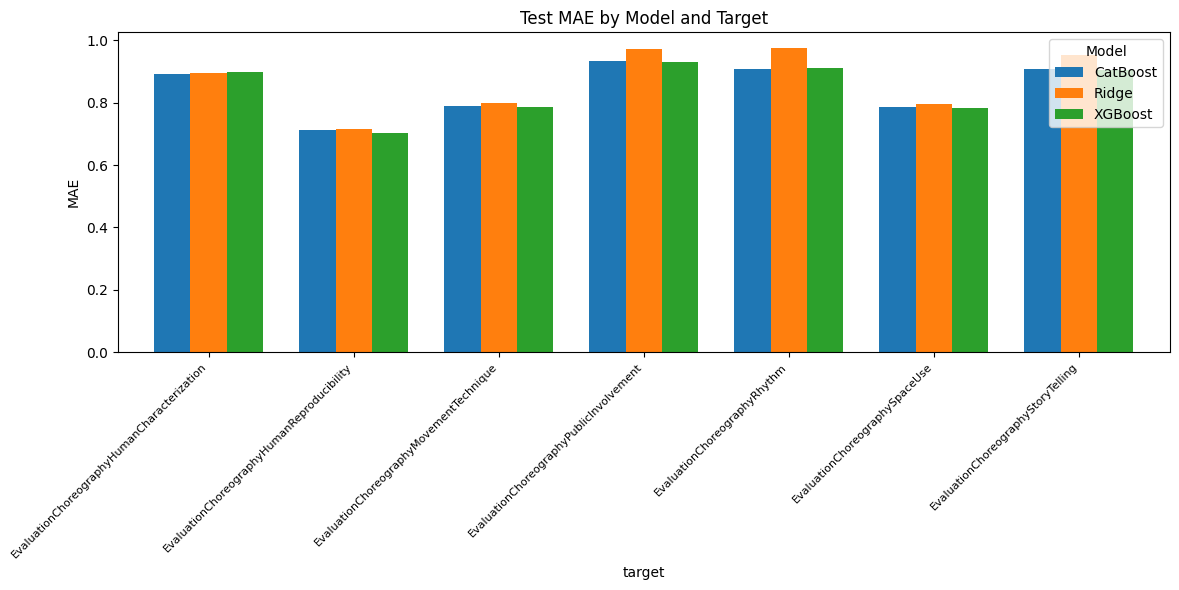

In [ ]:
plt.figure(figsize=(12,6))
mae_piv = metrics_df.pivot(index='target', columns='model', values='MAE')
mae_piv.plot(kind='bar', width=0.75, ax=plt.gca())
plt.title('Test MAE by Model and Target')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

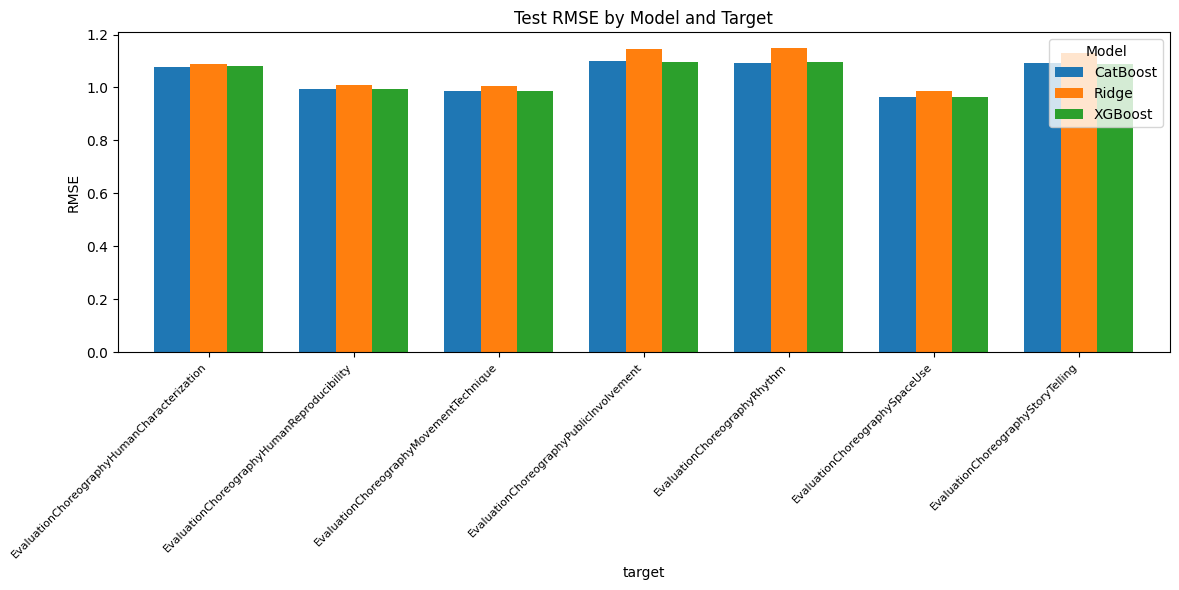

In [ ]:
plt.figure(figsize=(12,6))
mae_piv = metrics_df.pivot(index='target', columns='model', values='RMSE')
mae_piv.plot(kind='bar', width=0.75, ax=plt.gca())
plt.title('Test RMSE by Model and Target')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

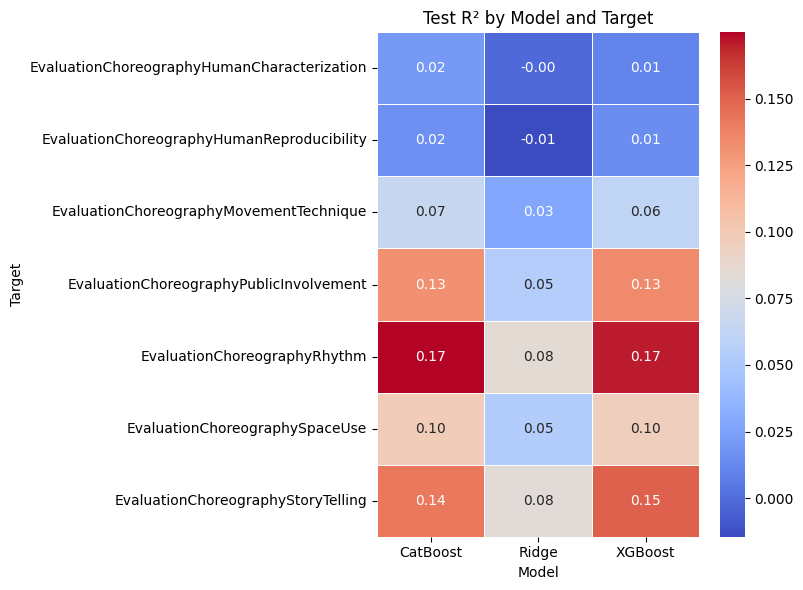

In [ ]:
plt.figure(figsize=(8,6))
r2_piv = metrics_df.pivot(index='target', columns='model', values='R2')
sns.heatmap(r2_piv, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Test R² by Model and Target')
plt.ylabel('Target')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

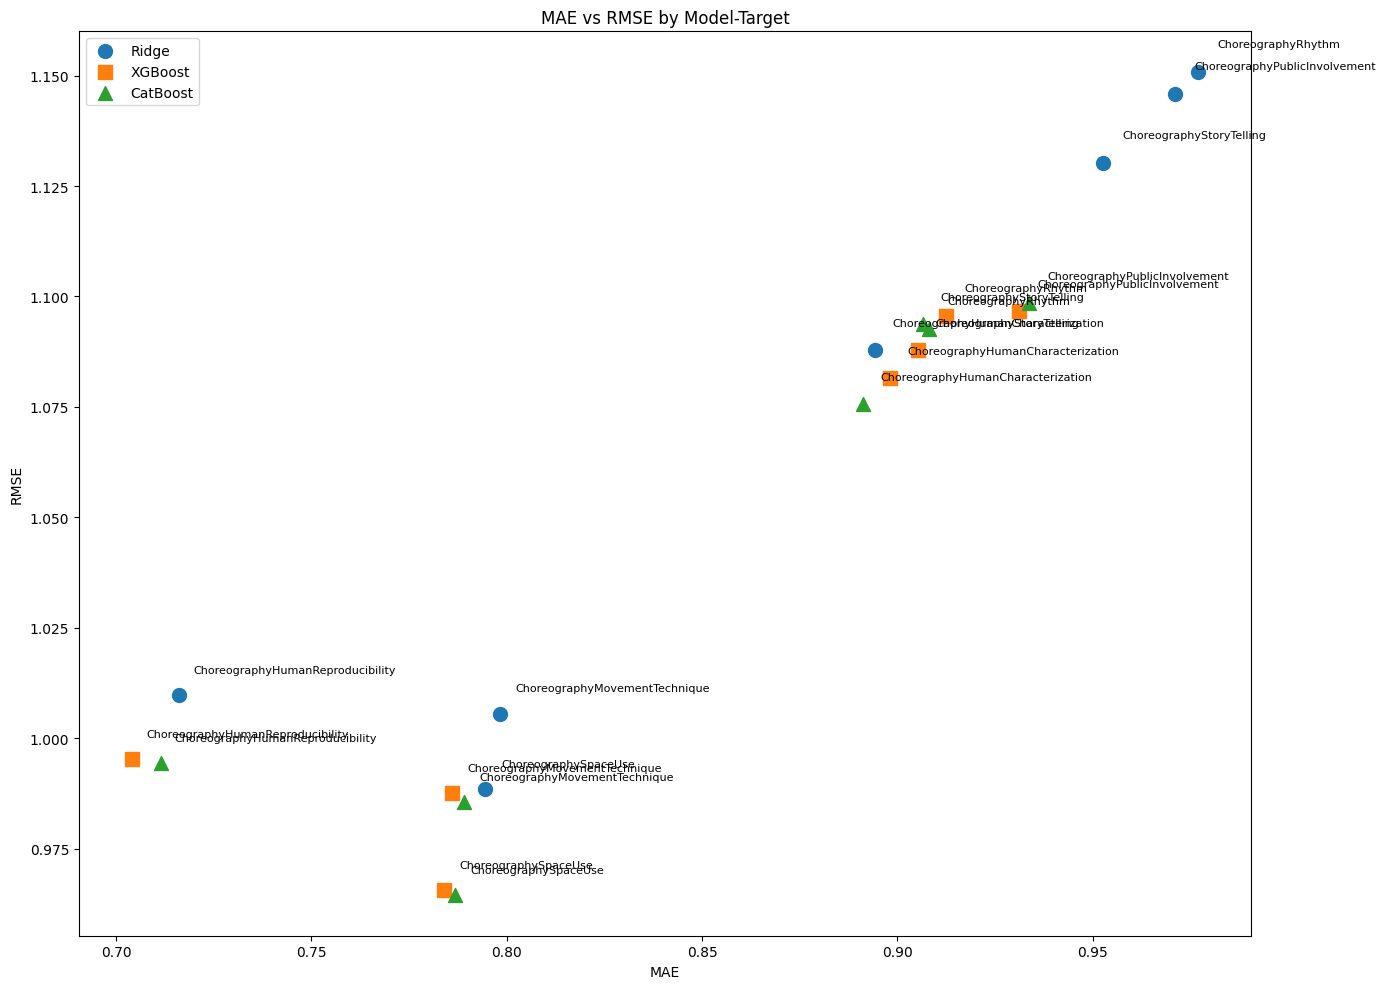

In [ ]:
plt.figure(figsize=(14,10))
markers = {'Ridge':'o','XGBoost':'s','CatBoost':'^'}
for mdl in metrics_df['model'].unique():
    sub = metrics_df[metrics_df['model']==mdl]
    plt.scatter(sub['MAE'], sub['RMSE'], label=mdl,
                marker=markers.get(mdl,'o'), s=100)
    for _, r in sub.iterrows():
        plt.text(r['MAE']*1.005, r['RMSE']*1.005,
                 r['target'].split('Evaluation')[-1], fontsize=8)
plt.title('MAE vs RMSE by Model-Target')
plt.xlabel('MAE')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()